# Multilingual Sense Intersection (MSI) 
# on a subset of parallel SemCor corpora

An ambiguous word will often be translated in different words in another language. A polysemous word in the target text can be easily disambiguated if its translation in another language is monosemous. As a consequence, the knowledge of all the senses associated to its translation can help detect the sense actually intended in the original text. 

Consider, for instance, the problem of disambiguating the English word "administration" given the following sentence pairs:

(EN) The jury praised the administration and operation of the Atlanta Police Department.
(IT) Il jury ha elogiato l'amministrazione e l'operato del Dipartimento di Polizia di Atlanta.
(RO) Juriul a laudat administrarea} si conducerea Sectiei de politie din Atlanta.
(JP) 陪審 団 は 、 アトランタ 警察 署 の \underline{陣営} と 働き を 賞賛 し た 。

The figure below shows that by comparing all senses available for the target lemma and its translation equivalent, we can obtain the correct sense, i.e. the only one shared by all: administration.n.01

In [1]:
import json_files_reader as jfr
from nltk.corpus import wordnet as wn
import msi_utils as msiu
import msi as msi
from pprint import pprint
from IPython.display import Image
from IPython.core.display import HTML 

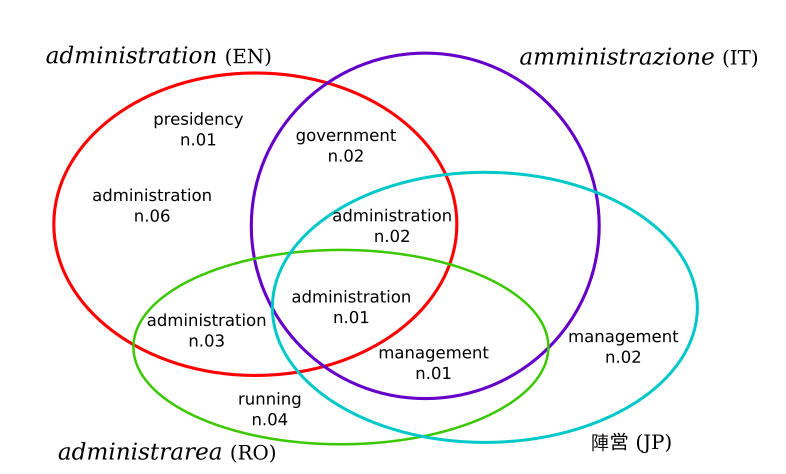

In [23]:
Image(filename = "../resources/images/int4.png", width=500, height=500)

## Multilingual Sense Intersection

The above process is hereby called Multilingual Sense Intersection (MSI).

In this demo we attempt to perform MSI on SemCor and its sibling projects, in particular on the subset shared across all four components.


### Requirements

To work, MSI requires that the languages in the multilingual corpus have:
* a WordNet aligned to Princeton WordNet;
* alignments at the word level across the components.

## Algorithm outline

```
for each language corpus in MSI
  for each word to be sense-annotated
    look for aligned words in the parallel corpus
	given this translation tuple, assign each word its set of synsets in WordNet
	perform intersection progressively over each non-empty set of senses that has been retrieved
	end when the overlap contains one sense, else make a decision using heuristics```

### Possible scenarios after MSI: how to make a decision

```
if |overlap| = 1 --> Disambiguated
else if |overlap| > 1
  if available, intersect with general sense frequency statistics for the target lemma
    then:
      if |overlap| > 1, select sense with the relative highest frequency $\rightarrow$ RMSF_within_overlap
      else if |overlap| = 1 --> MFS_in_overlap
      else, assign MFS --> MFS
   else:
       resort to WN first sense (for English) or available SFS 
       if MFS is found:
           if |overlap $\cap$ mfs|, select MFS --> MFS_in_overlap
           else --> MFS
       else:
           select random sense in overlap --> random_in_overlap
```

## Load MPC (the subset of SemCor parallel corpus) and perform MSI

In [2]:
# load MPC
langs = ['eng', 'ita', 'jpn', 'ron']
path_to_files = '../files/json_files'

multilingual_corpus = jfr.read_input_files(path_to_files, langs)

The code above has created a Python object that is a self-contained multilingual corpus: each corpus has its own documents, sentences, words, annotations and alignments.
    
Inter-corpus alignments are cointained at the multilingual corpus level.

In [25]:
# how many monolingual corpora in multilingual_corpus?
print(len(multilingual_corpus))

4


In [24]:
# how many texts in each component?
for corpus_id, corpus in multilingual_corpus.corpora.items():
    print(f'{corpus_id}: {len(corpus)} documents')

jpn_sc: 49 documents
eng_sc: 49 documents
ita_sc: 49 documents
ron_sc: 49 documents


In [26]:
# what's in a sentence? (only content words are displayed for simplicity)
pprint(multilingual_corpus['eng_sc']['a01']['s_1'].to_json())

{'__args__': [],
 '__class__': 'Sentence',
 '__kw__': {'document': 'a01',
            'id': 's_1',
            'text': 'Fulton_County_Grand_Jury said Friday investigation '
                    'Atlanta recent primary_election produced evidence '
                    'irregularities took_place',
            'tokens': {'t_1_10': <corpus.Word object at 0x7f8d6d4dec18>,
                       't_1_11': <corpus.Word object at 0x7f8d6d4deca8>,
                       't_1_12': <corpus.Word object at 0x7f8d6d4ded38>,
                       't_1_15': <corpus.Word object at 0x7f8d6d4dedc8>,
                       't_1_19': <corpus.Word object at 0x7f8d6d4dee58>,
                       't_1_2': <corpus.Word object at 0x7f8d6d4de948>,
                       't_1_20': <corpus.Word object at 0x7f8d6d4deee8>,
                       't_1_3': <corpus.Word object at 0x7f8d6d4de9d8>,
                       't_1_4': <corpus.Word object at 0x7f8d6d4dea68>,
                       't_1_6': <corpus.Word object

The above is the internal representation of a **Sentence** object inside the multilingual corpus. A sentence belongs to a document, has its own id, the raw text (here, only content words are displayed) and a set of tokens that together build the raw text.


In [27]:
# and what's in a token, then? 
pprint(multilingual_corpus['eng_sc']['a01']['s_1']['t_1_4'].to_json())

{'__args__': [],
 '__class__': 'Word',
 '__kw__': {'alignments': {'ita': <corpus.Word object at 0x7f8d6b232438>,
                           'jpn': <corpus.Word object at 0x7f8d68f6f708>},
            'document': 'a01',
            'equivalent_wn_senses': [],
            'external_sense': None,
            'id': 't_1_4',
            'lang': 'eng',
            'lemma': 'friday',
            'msi_annotation': <corpus.MsiAnnotation object at 0x7f8d50e183a8>,
            'pos': 'n',
            'sense': '15164463-n',
            'sentence': 's_1',
            'surface_form': 'Friday'}}


Here we are looking at the 4th token in sentence 1, document a01, in English SemCor.

The token above has word alignment to Italian and Japanese. 

Further information about it are lemma, surface form, pos, sense (as in the original corpus, later used for evaluation) and a series of optional attributes, in case the corpus comes with more than one level of annotation (as Romanian and Japanese SemCor do).

Also note that, since MSI has not yet been performed, the ```msi_annotation``` attribute is None.

In [28]:
# let's check out the alignments
target_word = multilingual_corpus['eng_sc']['a01']['s_1']['t_1_4']
for language_aligned in target_word.alignments:
    pprint(target_word.alignments[language_aligned].to_json())

{'__args__': [],
 '__class__': 'Word',
 '__kw__': {'alignments': {'eng': <corpus.Word object at 0x7f8d6d4dea68>,
                           'ron': <corpus.Word object at 0x7f8d65c1e0d8>},
            'document': 'a01',
            'equivalent_wn_senses': [],
            'external_sense': None,
            'id': 't_1_1',
            'lang': 'ita',
            'lemma': 'venerdì',
            'msi_annotation': <corpus.MsiAnnotation object at 0x7f8d4f71cbd0>,
            'pos': 'n',
            'sense': '15164463-n',
            'sentence': 's_1',
            'surface_form': 'Venerdì'}}
{'__args__': [],
 '__class__': 'Word',
 '__kw__': {'alignments': {'eng': <corpus.Word object at 0x7f8d6d4dea68>},
            'document': 'a01',
            'equivalent_wn_senses': ['15164463-n'],
            'external_sense': '金曜日-n',
            'id': 'w1.1.6',
            'lang': 'jpn',
            'lemma': '金曜日',
            'msi_annotation': <corpus.MsiAnnotation object at 0x7f8d53fb86c0>,
            

The above snippet and output show detail of how are internally represented the aligned translation of a target word. 

English SemCor token t_1_4 is aligned to Italian *Friday* and Japanese *金曜日*. From the representation of each, it can be noted that the Italian, in turn, has word alignments with English (our starting lemma) and Romanian, while Japanese is only in turn aligned with English.

Japanese tokens may look a little different - they have external sense tagging, too! See example below.

In [32]:
pprint(multilingual_corpus['jpn_sc']['a01']['s_1']['w1.1.36'].to_json())

{'__args__': [],
 '__class__': 'Word',
 '__kw__': {'alignments': {},
            'document': 'a01',
            'equivalent_wn_senses': ['00664788-v',
                                     '00772640-v',
                                     '00772967-v',
                                     '00820976-v',
                                     '00921300-v',
                                     '00921738-v',
                                     '00922867-v',
                                     '00923307-v',
                                     '00923793-v',
                                     '00924612-v',
                                     '00928015-v',
                                     '00931467-v',
                                     '00932161-v',
                                     '00936330-v',
                                     '00943837-v',
                                     '00987071-v',
                                     '01015244-v',
                                 

Now that we have familiarize ourselves with the internal format, it's time to dig deeper and have a look at MSI results.

Synset bags for each aligned translation are produced and then, progressively, intersection is computed over every non-empty set.

If the intersection doesn't lead to overlap, the heuristics in algorithm outline above are applied.

In [35]:
msi.apply_msi_to_corpus(multilingual_corpus, langs, use_sense_frequencies=True)
print("MSI has been carried out")

External sense frequencies enabled...
MSI has been carried out


In [29]:
# This is for evaluation - but be aware, output is very verbose!
#msi.evaluate_msi(multilingual_corpus)

Results from the above method are reported in the table below.

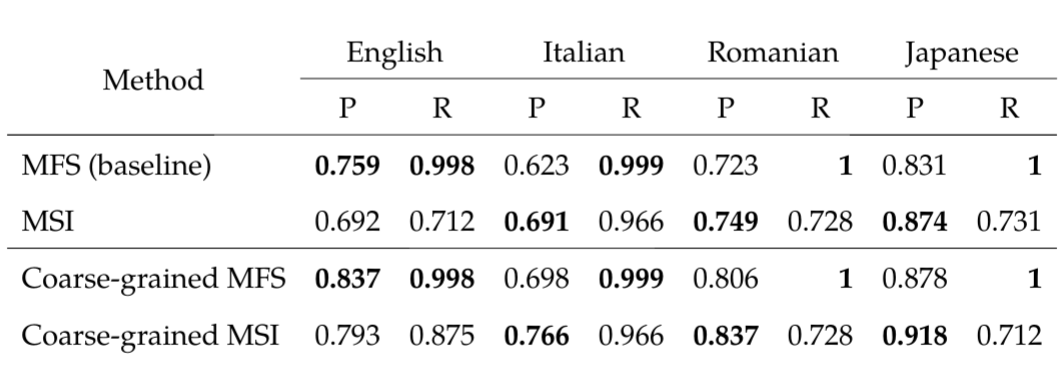

In [22]:
Image(filename = '../resources/images/results.png', width=600, height=600)

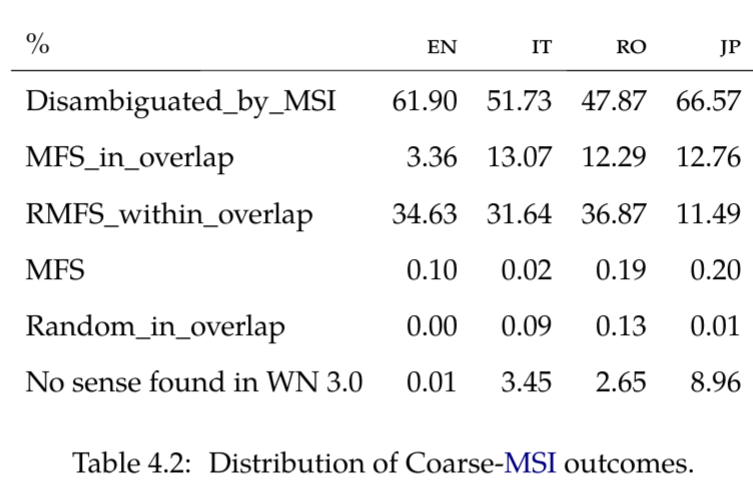

In [21]:
Image(filename = '../resources/images/overlap_outcomes.png', width=600, height=600)

Table 4.2 shows instead the different scenarios that may arise when disambiguating. Please note that MSI alone manages to find the correct sense, on average across languages, in more than half the cases.

In [30]:
#This dumps the annotated multilingual corpus as a XML file on your disk!

msiu.dump_multilingual_corpus_to_xml(multilingual_corpus)

File MPC.xml created
